In [88]:
using NCDatasets
using Statistics
using Dates
using DataFrames
using Printf
using CairoMakie
# we need the following variables to drive scm 
# ta, hus, ua, va, zg, z, wap, rsdt, tntha, tnhusha, tntva, tnhusva

In [ ]:
# configuration parameters 
time_resolution = 3600 

# test load geo
geo = NCDataset("/scratch/julian/ERA5/geolocation.nc")   
geo["lon"][23]

# pick location, site 17
lat = 17.
lon = 211. - 360. # convert to -180, 180

In [ ]:
era5_to_clima_name_conventions = Dict(
    "t" => "ta",
    "u" => "ua",
    "v" => "va",
    "w" => "wa",
    "q" => "hus",
    "slhf" => "hfls",
    "sshf" => "hfss",
    "skt" => "ts",
    "tisr" => "rsdt",
    "z" => "zg"
);

In [1]:
# forcing dataset 
tvforcing = NCDataset("/scratch/julian/ERA5/tv/time_varying_site23_ng.nc")
#tvforcing_surface = NCDataset("/scratch/julian/ERA5/tv/tv_site23_surface.nc")
# # rename variables to clima convenctions 
# for (era5_name, clima_name) in era5_to_clima_name_conventions
#     if haskey(tvforcing, era5_name)
#         tvforcing[clima_name] = tvforcing[era5_name]
#         #delete!(tvforcing, era5_name)
#     end
# end

# tvforcing

LoadError: UndefVarError: `NCDataset` not defined

In [ ]:
t = findfirst(tvforcing["longitude"][:] .== 211-360)
println(t)
tvforcing["longitude"][:]

In [ ]:
function get_horizontal_tendencies(lon_index, lat_index, column_ds)
    """
    Computes horizontal tendencies for temperature and specific humidity at a given location.
    """
    rearth = 6378e3
    lat_rad = deg2rad(lat)
    lon_rad = deg2rad(lon - 360)
    coslat = cos(lat_rad)
    dx = 2 * π * rearth * coslat / 360 * 0.25
    dy = 2 * π * rearth / 360 * 0.25

    # lon_index = findfirst(column_ds["longitude"][:] .== lon)
    # lat_index = findfirst(column_ds["latitude"][:] .== lat)
    println(lon_index, lat_index)
    # get velocities at site location
    ᶜu = column_ds["u"][lon_index, lat_index, :, :]
    ᶜv = column_ds["v"][lon_index, lat_index, :, :]

    # get temperature at N S E W of center for gradient calculation
    ʷT = column_ds["t"][lon_index, lat_index - 1, :, :]
    ⁿT = column_ds["t"][lon_index + 1, lat_index, :, :]
    ˢT = column_ds["t"][lon_index - 1, lat_index, :, :]
    ᵉT = column_ds["t"][lon_index, lat_index + 1, :, :]

    # get specific humidity at N S E W of center for gradient calculation
    ʷq = column_ds["q"][lon_index, lat_index - 1, :, :]
    ⁿq = column_ds["q"][lon_index + 1, lat_index, :, :]
    ˢq = column_ds["q"][lon_index - 1, lat_index, :, :]
    ᵉq = column_ds["q"][lon_index, lat_index + 1, :, :]

    # temperature and specific humidity advective tendency at center 
    tntha = -(ᶜu .* (ᵉT .- ʷT) ./ (2dx) .+ ᶜv .* (ⁿT .- ˢT) ./ (2dy))
    tnhusha = -(ᶜu .* (ᵉq .- ʷq) ./ (2dx) .+ ᶜv .* (ⁿq .- ˢq) ./ (2dy))

    return tntha, tnhusha
end

# compute vertical advection terms
function get_vertical_tendencies(column_ds, var, vertvar = "wap")
    """
    Calculate the temperature and specific humidity vertical tendencies as a function of levels
    using vertical advection. Here we take the tendency over the geopotential height not the height in meters
    """
    deriv = zeros(size(sim_forcing["wap"]))

    for i in 1:size(sim_forcing["wap"])[1]
        if i == 1
            deriv[1, :] = sim_forcing["wap"][1, :] .* (sim_forcing[var][2, :] .- sim_forcing[var][1, :]) ./ (sim_forcing["zg"][2, :] .- sim_forcing["zg"][1, :])
        elseif i == size(sim_forcing["wap"])[1]
            deriv[end, :] = sim_forcing["wap"][end, :] .* (sim_forcing[var][end, :] .- sim_forcing[var][end-1, :]) ./ (sim_forcing["zg"][end, :] .- sim_forcing["zg"][end-1, :])
        else # centered FD 
            deriv[i, :] = sim_forcing["wap"][i, :] .* (sim_forcing[var][i+1, :] .- sim_forcing[var][i-1, :]) ./ (sim_forcing["zg"][i+1, :] .- sim_forcing["zg"][i-1, :])
        end
    end
    
    deriv 
end

lines(get_horizontal_tendencies(t, t, tvforcing)[2][:, 1])

In [ ]:
R_d = 287.05
g = -9.81

temperature = tvforcing["t"]
pressure = tvforcing["pressure_level"] .* 100
ρ = reshape(pressure, 1, 1, 37, 1) ./ (R_d .* temperature)
wap = tvforcing["w"] .* ρ

# tvforcing["wap"] = wap

In [ ]:
typeof(tvforcing["valid_time"][:][1])

In [ ]:
using Dates
using Statistics

using Insolation
import Insolation.Parameters as IP 
import ClimaParams as CP

using NCDatasets

FT = Float64

function get_coszen_inst(lat, lon, date,
    param_set = IP.InsolationParameters(FT),
    od = Insolation.OrbitalData())

    date = DateTime(date)

    date0 = DateTime("2000-01-01T11:58:56.816")

    S, μ = solar_flux_and_cos_sza(date, date0, od, FT(lon), FT(lat), param_set)

    return μ, S * μ
end

coszen_list = get_coszen_inst.(lat, lon, tvforcing["valid_time"][:])


In [ ]:
# validate the coszen values (should be hot when sun is up :))
fig = Figure()
ax_left = Axis(fig[1, 1], xlabel = "Time", ylabel = "T [K]")
lines!(ax_left, Dates.DateTime.(tvforcing["valid_time"][:]), mean(tvforcing["t"][:, :, 1, :], dims = (1,2))[:])
ax_right = Axis(fig[1, 2], xlabel = "Time", ylabel = "cos(zenith)")
lines!(ax_right, Dates.DateTime.(tvforcing["valid_time"][:]), coszen_list)

fig

In [ ]:
# script to run everything 
R_d = 287.05
g = -9.81

sim_forcing = Dict()
sim_forcing["time"] = tvforcing["valid_time"][:]
sim_forcing["pressure_level"] = tvforcing["pressure_level"][:]

lat = 17.
lon = 211. - 360. # convert to -180, 180
lon_index = findfirst(tvforcing["longitude"][:] .== lon)
lat_index = findfirst(tvforcing["latitude"][:] .== lat)

sim_forcing["ua"] = tvforcing["u"][lon_index, lat_index, :, :]
sim_forcing["va"] = tvforcing["v"][lon_index, lat_index, :, :]
sim_forcing["wa"] = tvforcing["w"][lon_index, lat_index, :, :]
sim_forcing["hus"] = tvforcing["q"][lon_index, lat_index, :, :]
sim_forcing["ta"] = tvforcing["t"][lon_index, lat_index, :, :]
sim_forcing["zg"] = tvforcing["z"][lon_index, lat_index, :, :]



# compute subsidence
pressure = tvforcing["pressure_level"] .* 100
ρ = reshape(pressure, 37, 1) ./ (R_d .* sim_forcing["ta"])
sim_forcing["wap"] = sim_forcing["wa"] .* ρ

sim_forcing["tntha"], sim_forcing["tnhusha"] = get_horizontal_tendencies(lon_index, lat_index, tvforcing)

# compute vertical advection terms - for these terms we don't need horizontal gradients so can pass sim_forcing directly
sim_forcing["tntva"] = get_vertical_tendencies(sim_forcing, "ta", "wap")
sim_forcing["tnhusva"] = get_vertical_tendencies(sim_forcing, "hus", "wap")


sim_forcing["rho"] = ρ # pressure 
sim_forcing["z"] = tvforcing["z"][lon_index, lat_index, :, :] / (-g) # height in meters

In [ ]:
coszen_list = get_coszen_inst.(lat, lon, Dates.DateTime.(tvforcing["valid_time"][:]))

In [ ]:
using NCDatasets

# Create a new NetCDF file and define the dimensions and variables
ds = Dataset("sim_forcing_site23.nc", "c")
group = defGroup(ds, "site23")


# Define the dimensions
defDim(group, "time", length(sim_forcing["time"]))
defDim(group, "pressure_level", length(sim_forcing["pressure_level"]))

# Convert DateTime to numeric values
time_values = Float64.(Dates.value.(sim_forcing["time"] .- sim_forcing["time"][1]) ./ 1000)

# Define time variable with attributes
defVar(group, "time", Float64, ("time",),
    attrib = [
        "units" => "hours since 1970-01-01 00:00:00",
        "calendar" => "proleptic_gregorian"
    ]
)
group["time"][:] = time_values

# Define other variables
defVar(group, "pressure_level", Float64, ("pressure_level",))
group["pressure_level"][:] = sim_forcing["pressure_level"]

# Define the variables and add them to the group
for (name, data) in sim_forcing
    if name in ["tnhusha", "tntha", "hus", "tntva", "zg", "wa", "ua", "va", "ta", "tnhusva", "wap", "rho", "z"]
        defVar(group, name, Float64, ("pressure_level", "time"))
        group[name][:, :] = data
    elseif name ∉ ["time", "pressure_level"]
        defVar(group, name, Float64, ("time", "pressure_level"))
        group[name][:, :] = data
    end
end

# add coszen 
defVar(group, "coszen", Float64, ("time",))
group["coszen"][:] = coszen_list

# Close the dataset
close(ds)

In [ ]:
lines(mean(sim_forcing["wap"], dims = 2)[:])

In [ ]:
lines(mean(get_vertical_tendencies(sim_forcing, "ta", "wap"), dims = 2)[:])

In [ ]:
fig, ax, hm = heatmap(get_vertical_tendencies(sim_forcing, "ta", "wap"), colormap =:inferno, colorrange = (-0.0001, 0.0001))
Colorbar(fig[:, end+1], hm)
fig

In [ ]:
tvforcing["valid_time"][:]

In [ ]:
# load surface variables 
tv_site23_surface = NCDataset("/scratch/julian/ERA5/tv/site23_surface_forcing1.nc")
matching_time_indices = findall(in(tvforcing["valid_time"][:]), tv_site23_surface["valid_time"][:])

lat = 17.
lon = 211. - 360. # convert to -180, 180
lon_index_surf = findfirst(tv_site23_surface["longitude"][:] .== lon)
lat_index_surf = findfirst(tv_site23_surface["latitude"][:] .== lat)
print(lon_index_surf, lat_index_surf)
- tv_site23_surface["slhf"][lon_index_surf, lat_index_surf, matching_time_indices] / time_resolution
- tv_site23_surface["sshf"][lon_index_surf, lat_index_surf, matching_time_indices] / time_resolution
t = tv_site23_surface["tisr"][lon_index_surf, lat_index_surf, matching_time_indices] / time_resolution;

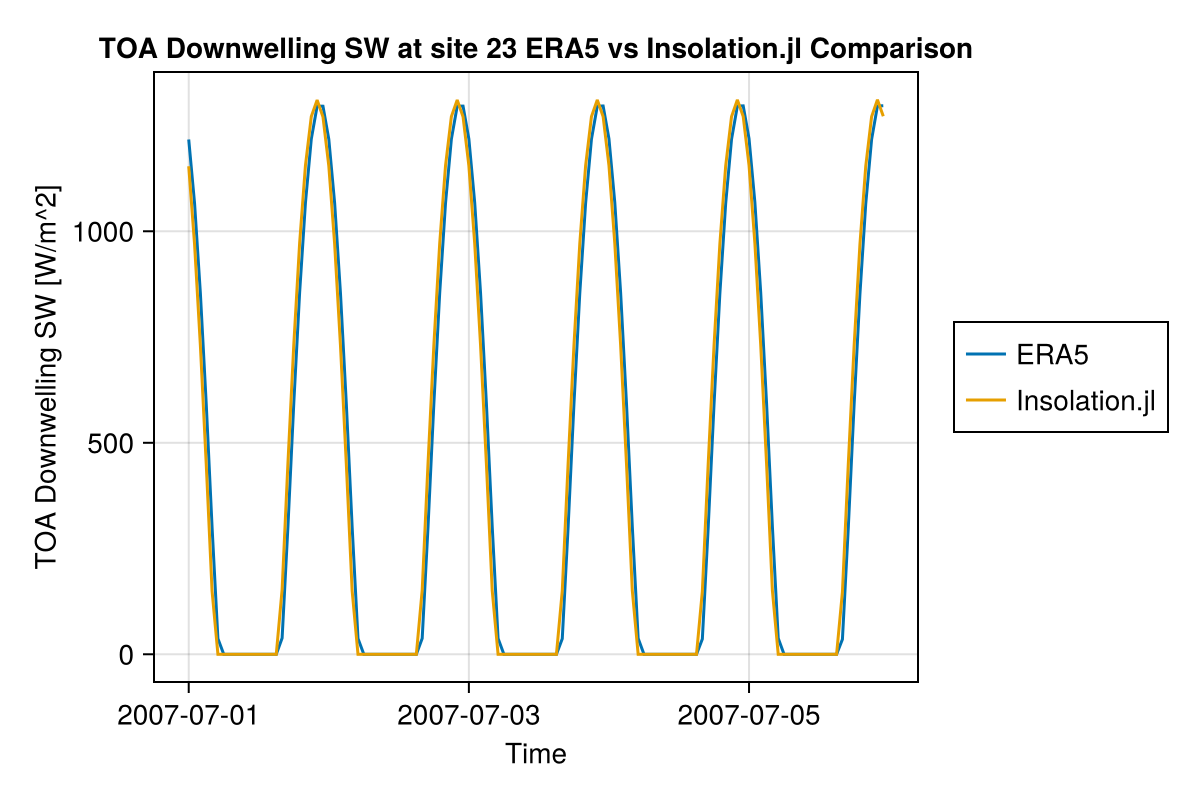

In [84]:
fig = Figure(size=(600, 400))

ax = Axis(fig[1, 1], xlabel = "Time", ylabel = "TOA Downwelling SW [W/m^2]",
    title = "TOA Downwelling SW at site 23 ERA5 vs Insolation.jl Comparison")

lines!(ax, tvforcing["valid_time"][:], t, label = "ERA5")
lines!(ax, tvforcing["valid_time"][:], [c[2] for c in coszen_list], label = "Insolation.jl")

# legend
fig[1,2] = Legend(fig, ax)

# save figure 
save("/home/jschmitt/Plots/toa_downwelling_sw_comparison.png", fig, dpi =200)
fig

In [ ]:
tv_site23_surface2 = NCDataset("/scratch/julian/ERA5/tv/site23_surface_forcing2.nc")
group["ts"][:] = tv_site23_surface2["skt"][lon_index_surf, lat_index_surf, matching_time_indices]


120-element Vector{Union{Missing, Float32}}:
 297.8563f0
 297.8337f0
 297.82364f0
 297.81537f0
 297.83636f0
 297.83188f0
 297.84613f0
 297.8443f0
 297.839f0
 297.8371f0
 297.85394f0
 297.85468f0
 297.86224f0
   ⋮
 297.88574f0
 297.87558f0
 297.88043f0
 297.8938f0
 297.89307f0
 297.87708f0
 297.85095f0
 297.86078f0
 297.89642f0
 297.917f0
 297.9253f0
 297.91565f0